In [1]:
import random
import numpy as np
import tensorflow as tf
from IPython.display import clear_output
k = tf.keras

In [2]:
import gym
env = gym.make('CartPole-v1')

### Whitening Transformation

In [3]:
k.backend.clear_session()

In [4]:
pg = k.Sequential([
    k.layers.Input(shape=[4]),
    k.layers.Dense(units=16,activation='relu'),
    k.layers.Dense(units=16,activation='relu'),
    k.layers.Dense(units=2,activation='softmax')
])

2021-10-28 20:12:59.127574: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
pg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


In [6]:
def get_action(obs):
    probs = pg(obs)[0].numpy()
    probs[-1] = 1-np.sum(probs[:-1]) #handle floating point error
    action = np.random.choice([0,1], p=probs)
    return action

def pg_loss(states, actions, returns):
    # whitening / normalizing the discounted returns
    returns = (returns - np.mean(returns))/np.var(returns)
    
    probs = pg(states)
    indices = [(i,j) for i,j in enumerate(actions)]
    
    actions_prob = tf.gather_nd(probs,indices)
    logp = tf.math.log(actions_prob)
    return -tf.reduce_mean(logp * returns)

In [7]:
MAX_ITER = 1000 
EPISODES = 1000
DISCOUNT = 0.99

In [8]:
optimizer = k.optimizers.Adam(0.004)

In [9]:
history = {
    'losses': [],
    'rewards': [],
}

In [12]:
for e in range(EPISODES):
    done = False
    state = env.reset()
    states = []
    actions = []
    rewards = []
    
    i = 0
    while not done and i < MAX_ITER:
        states.append(state.copy())
        
        action = get_action(state.reshape((1,-1)))
        actions.append(action)
        
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        
        state = next_state
        i+=1
    
    # Calculated the discounted reward
    # Reward in the future is less valueable than the beginning
    discounted_rewards = []
    total_r = 0
    for reward in reversed(rewards):
        total_r = reward + total_r ** DISCOUNT
        discounted_rewards.append(total_r)
    
    discounted_rewards = np.array(discounted_rewards)[::-1]
    
    with tf.GradientTape() as tape:
        loss = pg_loss(np.array(states), np.array(actions), discounted_rewards)
    
    grads = tape.gradient(loss, pg.trainable_weights)
    optimizer.apply_gradients(zip(grads, pg.trainable_weights))
    
    history['losses'].append(loss)
    history['rewards'].append(sum(rewards))
    print(f'Ep {e+1}: loss = {loss:.04f}, reward= {sum(rewards)}')
    clear_output(wait=True)

Ep 1000: loss = 0.0081, reward= 142.0


In [13]:
import matplotlib.pyplot as plt

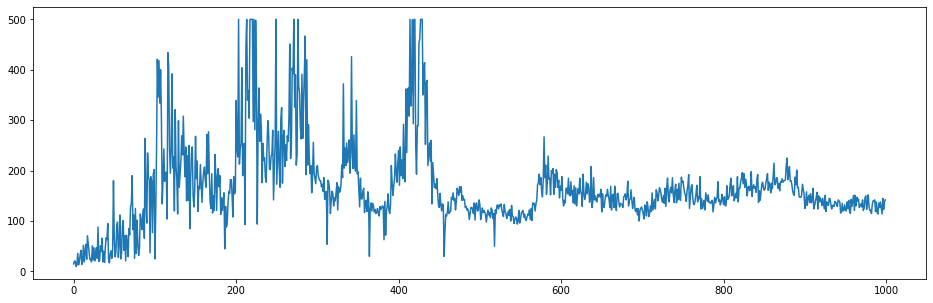

In [14]:
fig = plt.figure(figsize=[16,5])
plt.plot(history['rewards'])

In [15]:
scores = []
for e in range(100):
    state = env.reset()
    rewards = []
    done = False
    while not done:
        action = get_action(state.reshape(1,-1))
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
    scores.append(sum(rewards))

In [16]:
np.max(scores)

155.0

In [17]:
np.mean(scores)

130.15

### Q-value as baseline

In [37]:
k.backend.clear_session()

In [38]:
pg = k.Sequential([
    k.layers.Input(shape=[4]),
    k.layers.Dense(units=16,activation='relu'),
    k.layers.Dense(units=16,activation='relu'),
    k.layers.Dense(units=2,activation='softmax')
])


qmodel = k.Sequential([
    k.layers.Input(shape=[4]),
    k.layers.Dense(units=16,activation='relu'),
    k.layers.Dense(units=16,activation='relu'),
    k.layers.Dense(units=2,activation='linear')
])

In [39]:
def pg_loss(states, actions, returns):
    probs = pg(states)
    qvalues = qmodel(states)
    
    indices = [(i,j) for i,j in enumerate(actions)]
     
    
    actions_prob = tf.gather_nd(probs,indices)
    actions_qvalue = tf.gather_nd(qvalues,indices)
    
    logp = tf.math.log(actions_prob)
    return -tf.reduce_mean(logp * (returns - actions_qvalue))

def qmodel_loss(states, actions, returns):
    qvalues = qmodel(states)
    indices = [(i,j) for i,j in enumerate(actions)]
    
    action_qvalues = tf.gather_nd(qvalues, indices)
    return tf.losses.mse(returns, action_qvalues)

In [40]:
pg_optimizer = k.optimizers.Adam(0.002)
qmodel_optimizer = k.optimizers.Adam(0.002)

In [41]:
history = {
    'pg_losses': [],
    'qmodel_losses': [],
    'rewards': [],
}

In [42]:
for e in range(EPISODES):
    done = False
    state = env.reset()
    states = []
    actions = []
    rewards = []
    
    i = 0
    while not done and i < MAX_ITER:
        states.append(state.copy())
        
        action = get_action(state.reshape((1,-1)))
        actions.append(action)
        
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        
        state = next_state
        i+=1
    
    discounted_rewards = []
    total_r = 0
    for reward in reversed(rewards):
        total_r = reward + total_r ** DISCOUNT
        discounted_rewards.append(total_r)
    
    discounted_rewards = np.array(discounted_rewards)[::-1]
    
    states = np.array(states)
    actions = np.array(actions)
    
    with tf.GradientTape(persistent=True) as tape:
        ploss = pg_loss(states, actions, discounted_rewards)
        qloss = qmodel_loss(states, actions, discounted_rewards)
    
    pg_grads = tape.gradient(ploss, pg.trainable_weights)
    qmodel_grads = tape.gradient(qloss, qmodel.trainable_weights)
    
    del tape
    
    pg_optimizer.apply_gradients(zip(pg_grads, pg.trainable_weights))
    qmodel_optimizer.apply_gradients(zip(qmodel_grads, qmodel.trainable_weights))
    
    history['pg_losses'].append(ploss)
    history['qmodel_losses'].append(qloss)
    
    history['rewards'].append(sum(rewards))
    print(f'Ep {e+1}: ploss = {ploss:.04f}, qloss = {qloss:.04f}, reward = {int(sum(rewards))}')
    clear_output(wait=True)

Ep 1000: ploss = -0.7820, qloss = 33.5351, reward = 233


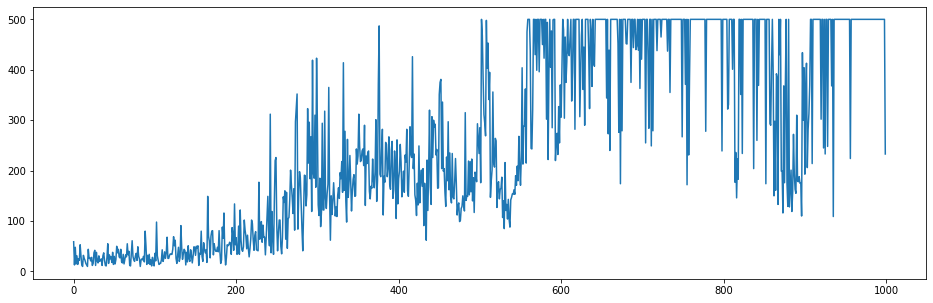

In [43]:
fig = plt.figure(figsize=[16,5])
plt.plot(history['rewards'])

In [44]:
scores = []
for e in range(100):
    state = env.reset()
    rewards = []
    done = False
    while not done:
        action = get_action(state.reshape(1,-1))
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
    scores.append(sum(rewards))

In [45]:
np.max(scores)

500.0

In [46]:
np.mean(scores)

491.89